In [1]:
import numpy as np
from scipy.special import comb
from scipy.stats import binom, bernoulli, beta
import pandas as pd
import seaborn as sns
import plotnine as gg

Here is a simple example to help you become familar with Bayes and the Bayesian formula.
The foundational insight of Bayes is that you should integrate your evidence (or data) with you prior (expectation, typically based on passed experiences or some other evidence).
It turns out that if you do so, **AND** your prior was accurate, your new beliefs will be the most accurate you can be (e.g., it is the optimal solution to dealing with uncertainty).
While the math for Bayes formula is not super difficult, the math to prove that it the optimal solution is advanced, so we will skip that here.

Let's use a simple example to understand Bayes.
Let's pretend you and your friend are trying to decide on who gets that last slice of cake, and you agree to use a coin to make the decision.
Luckily he has a coin, but you are not sure if the coin is fair, so he agrees to let you flip it as many times as you need to be convinced that it is a fair coin.
So you agree, but how many time should you flip the coin to be confident?

Well Bayes can help us quantify our uncertainy at any given point.
The Bayes formula is as follows:

$$p(Hyp | Data) = \frac{p(Data | Hyp) \times p(Hyp)}{p(Data)}$$

At first, it might feel a little overwhelming, so lets break it down:
- $p(Hyp | Data)$: This just means what is the probability (`p`) that a particular hypothesis (`hyp`) is true ***GIVEN*** (`|`) that you have a certain amount of evidence/data (`data`) available
- $p(Data | Hyp)$: Well now that you know the first one, this one should be easy. What is the probablity of observing this data ***GIVEN*** that a particular hypothesis is true.
- $p(Hyp)$: What is the probability that a particular hypothesis is true
- $p(Data)$: What is the probability of observing/recieving this data at all

See it wasn't that bad.
So let's break this down to really understand Bayes at a higher level.
The demoninator only changes if that data changes, so for a particular set of data, the bottom can be mostly ignored.
So, it is the numerator that really matters, so let's focus there.
This is just saying that the probability that a hypothesis (e.g., the coin is fair) given a certain number of coin flips depends on how likely it was to get that set of coin flips ***GIVEN*** the hypothesis is true times the probability that that hypothesis was true to begin with.

In [2]:
# See: https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_density.html#shading-a-region-under-a-density-curve
class geom_area_highlight(gg.geom_area):

    # new method
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f'{self.region[0]} <= x <= {self.region[1]}'  # new line
        data = data.query(s).reset_index(drop=True)       # new line
        return data

1


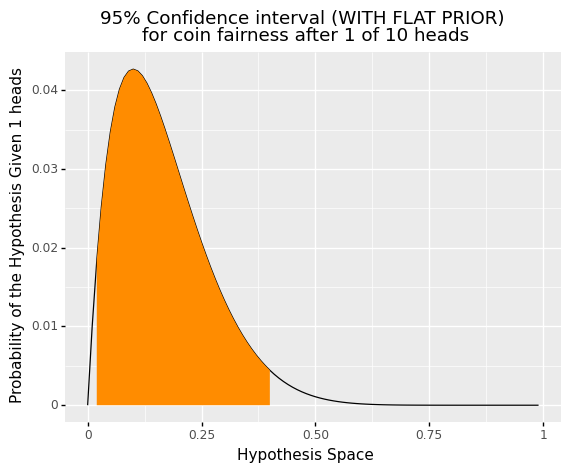

<ggplot: (8793543526805)>

In [3]:
# Next Update needs to incorporate making new geom's: https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_density.html#shading-a-region-under-a-density-curve
hyp = np.arange(0,1,.01)
pHyp = 1/hyp.size  # For fun, you could replace with a beta distribution for the prior like: beta.pdf(hyp, 4, 4), which indicates you think its likely fair but you are not sure
# Replacable with: binom.rvs(10, .5, size=1) in theory, but the way I made the code the following works better: np.random.rand(10) < .3
flips = np.random.rand(10) < .3
# Binomial Distribution: (n choose k) * p^k * (1 - p)^(n - k): binom.pmf(flips.sum(), flips.size, hyp)
pFlipHyp = comb(flips.size, flips.sum()) * hyp ** flips.sum() * (1 - hyp)**(flips.size - flips.sum())
# Bayes p(A|B) = (p(B | A) * p(A)) / (sum( p(B | A_i) * p(A_i)))
# Could also divide by cumsum().max(). Don't even need to * pHyp if prior is flat
pHypFlip = (pFlipHyp * pHyp) / (sum(pFlipHyp * pHyp))
print(flips.sum())
hypo_data = pd.DataFrame({'p(Hyp|Flips)': pHypFlip, 'hyp':hyp})
# sns.relplot(x='hyp', y='p(Hyp|Flips)', kind='line', data=hypo_data)#.set(ylim=[0,1])
fill_index = hypo_data.cumsum().query(".025 <= `p(Hyp|Flips)` <= .975").index
# hypo_data["fill"] = False
hypo_data.loc[fill_index, 'fill'] = True

flat_prior = (
    gg.ggplot(hypo_data, gg.aes(x="hyp", y="p(Hyp|Flips)"))
    + gg.geom_line()
    + geom_area_highlight(region=(hypo_data.loc[fill_index.min()].hyp, hypo_data.loc[fill_index.max()].hyp), fill="darkorange", show_legend = False)
    # + gg.geom_area(gg.aes(fill="fill"), show_legend = False)
    # + gg.scale_fill_manual(values=['dodgerblue', 'darkorange'])
    # + gg.geom_vline(xintercept = hypo_data.loc[fill_index.min()].hyp)
    # + gg.geom_vline(xintercept = hypo_data.loc[fill_index.max()].hyp)
    + gg.xlab("Hypothesis Space")
    + gg.ylab(f"Probability of the Hypothesis Given {flips.sum()} heads")
    + gg.labs(title=f"95% Confidence interval (WITH FLAT PRIOR) \nfor coin fairness after {flips.sum()} of {flips.size} heads")
)
flat_prior

## Testing out Beta Distributions for Priors

In [4]:
be_d = beta.pdf(hyp, 4, 4) / hyp.size
be_df = pd.DataFrame({"hyp": hyp, "pdf":be_d})
be_df.plot(kind = 'line', x="hyp", y="pdf")

<AxesSubplot:xlabel='hyp'>

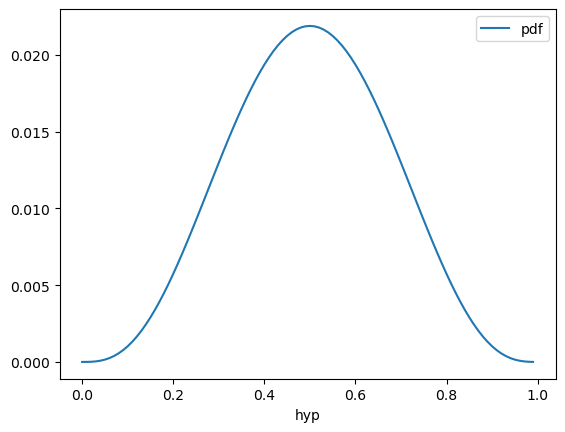

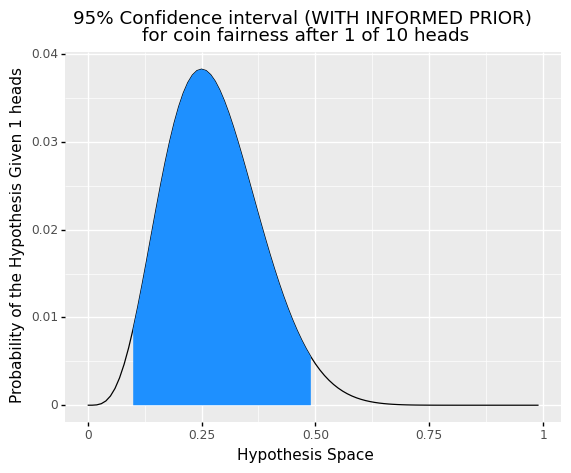

<ggplot: (8793546562693)>

In [5]:
pHyp = beta.pdf(hyp, 4, 4)
pHypFlip = (pFlipHyp * pHyp) / (sum(pFlipHyp * pHyp))
hypo_data = pd.DataFrame({'p(Hyp|Flips)': pHypFlip, 'hyp':hyp})
# sns.relplot(x='hyp', y='p(Hyp|Flips)', kind='line', data=hypo_data)#.set(ylim=[0,1])
fill_index = hypo_data.cumsum().query(".025 <= `p(Hyp|Flips)` <= .975").index
# hypo_data["fill"] = False
hypo_data.loc[fill_index, 'fill'] = True

prior_plot = (
    gg.ggplot(hypo_data, gg.aes(x="hyp", y="p(Hyp|Flips)"))
    + gg.geom_line()
    + geom_area_highlight(region=(hypo_data.loc[fill_index.min()].hyp, hypo_data.loc[fill_index.max()].hyp), fill="dodgerblue", show_legend = False)
    # + gg.geom_area(gg.aes(fill="fill"), show_legend = False)
    # + gg.scale_fill_manual(values=['dodgerblue', 'darkorange'])
    # + gg.geom_vline(xintercept = hypo_data.loc[fill_index.min()].hyp)
    # + gg.geom_vline(xintercept = hypo_data.loc[fill_index.max()].hyp)
    + gg.xlab("Hypothesis Space")
    + gg.ylab(f"Probability of the Hypothesis Given {flips.sum()} heads")
    + gg.labs(title=f"95% Confidence interval (WITH INFORMED PRIOR) \nfor coin fairness after {flips.sum()} of {flips.size} heads")
)
prior_plot

### Comparing Posterior WITH and WITHOUT an Informative Prior

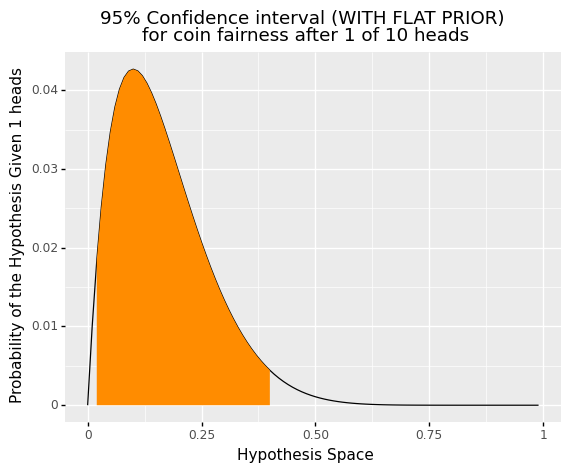

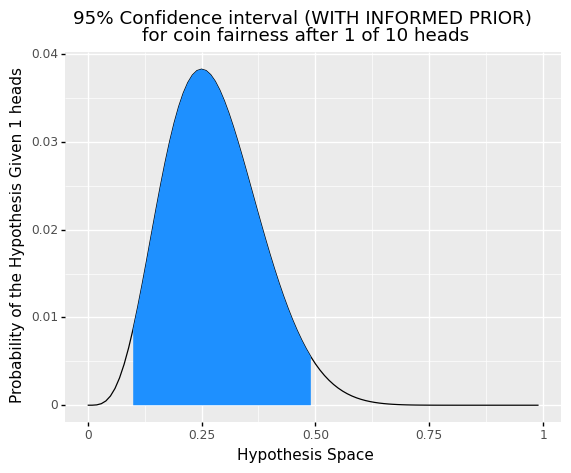

<ggplot: (8793546562693)>

In [6]:
# multi plot see here: https://stackoverflow.com/a/70829701
flat_prior.draw()
prior_plot

## Proof you can use Binom

In [7]:
binom.pmf(5, 10, hyp)
# binom.ppf(0.01, 10, .5)
print(np.allclose(pFlipHyp, binom.pmf(3, 10, hyp)))
t = pd.DataFrame({"hyp":hyp, "0": pFlipHyp, "1":binom.pmf(3, 10, hyp), "2": hypo_data["p(Hyp|Flips)"]})
key = ["0", "1"]
t[key] = t[key].div(9.09091)
t.plot(kind = 'line', x="hyp", y="0")
t.plot(kind = 'line', x="hyp", y="1")
t.plot(kind = 'line', x="hyp", y="2")
t.cumsum().iloc[-1].div(9.09091)
t

False


,hyp,0,1,2
0,0.00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.01,1.004869e-02,1.230326e-05,2.742475e-06
2,0.02,1.834245e-02,9.167405e-05,3.884662e-05
3,0.03,2.508762e-02,2.879651e-04,1.738866e-04
4,0.04,3.047149e-02,6.348228e-04,4.853053e-04
...,...,...,...,...
95,0.95,2.041015e-12,8.841679e-09,6.152545e-14
96,0.96,2.768240e-13,1.913408e-09,4.408848e-15
97,0.97,2.100176e-14,2.634741e-10,1.455668e-16
98,0.98,5.519359e-16,1.590238e-11,1.168919e-18
